# Truck Device Failure Classification

Objective: Build a machine-learning model to detect the truck device failure in the future.

Goal: Precision and recall score should be greater than 60% for this project.

*This notebook was organized after initial work.*

# Import Dependencies

In [371]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Scaler & Encoder
from sklearn.preprocessing import MinMaxScaler
import category_encoders as ce

# Model selection
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler

# Model
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# Score
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

# Data Acquisition

In [372]:
df = pd.read_csv(r"C:\Users\nene0\Desktop\Projects\truck_device_failure\truck-device-failure\device_failure.csv")

df.head()

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,0,7
1,2015-01-01,S1F0166B,0,61370680,0,3,0,6,403174,0,0,0
2,2015-01-01,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,0
3,2015-01-01,S1F01JE0,0,79694024,0,0,0,6,410186,0,0,0
4,2015-01-01,S1F01R2B,0,135970480,0,0,0,15,313173,0,0,3


In [373]:
df.shape

(124494, 12)

In [374]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124494 entries, 0 to 124493
Data columns (total 12 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   date        124494 non-null  object
 1   device      124494 non-null  object
 2   failure     124494 non-null  int64 
 3   attribute1  124494 non-null  int64 
 4   attribute2  124494 non-null  int64 
 5   attribute3  124494 non-null  int64 
 6   attribute4  124494 non-null  int64 
 7   attribute5  124494 non-null  int64 
 8   attribute6  124494 non-null  int64 
 9   attribute7  124494 non-null  int64 
 10  attribute8  124494 non-null  int64 
 11  attribute9  124494 non-null  int64 
dtypes: int64(10), object(2)
memory usage: 11.4+ MB


# Data Analysis

In [375]:
df.head()

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,0,7
1,2015-01-01,S1F0166B,0,61370680,0,3,0,6,403174,0,0,0
2,2015-01-01,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,0
3,2015-01-01,S1F01JE0,0,79694024,0,0,0,6,410186,0,0,0
4,2015-01-01,S1F01R2B,0,135970480,0,0,0,15,313173,0,0,3


In [376]:
df.duplicated().sum()

0

In [377]:
df.describe()

,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
count,124494.000000,1.244940e+05,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000
mean,0.000851,1.223868e+08,159.484762,9.940455,1.741120,14.222693,260172.858025,0.292528,0.292528,12.451524
std,0.029167,7.045960e+07,2179.657730,185.747321,22.908507,15.943021,99151.009852,7.436924,7.436924,191.425623
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000,1.000000,8.000000,0.000000,0.000000,0.000000
25%,0.000000,6.127675e+07,0.000000,0.000000,0.000000,8.000000,221452.000000,0.000000,0.000000,0.000000
50%,0.000000,1.227957e+08,0.000000,0.000000,0.000000,10.000000,249799.500000,0.000000,0.000000,0.000000
75%,0.000000,1.833084e+08,0.000000,0.000000,0.000000,12.000000,310266.000000,0.000000,0.000000,0.000000
max,1.000000,2.441405e+08,64968.000000,24929.000000,1666.000000,98.000000,689161.000000,832.000000,832.000000,18701.000000


Looks like 'attribute7' and 'attribute8' are exactly the same. Need to drop one of the features as they hold same information.

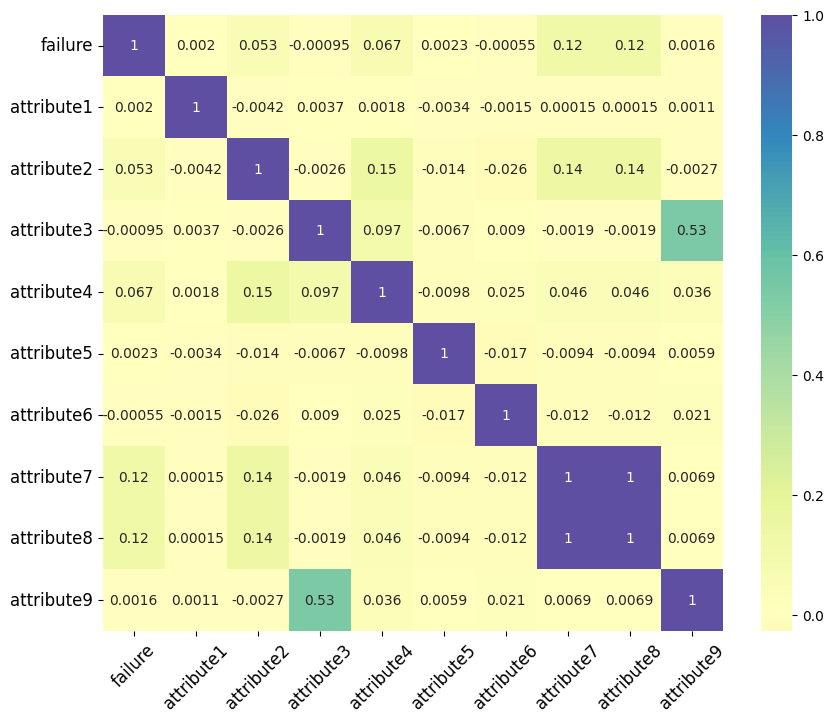

In [378]:
plt.figure(figsize=(10,8))
sns.heatmap(df.select_dtypes(exclude='object').corr(), cmap='Spectral', center=0, annot=True)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12, rotation=360)
plt.show()

The 'attribute7' and 'attribute8' are identical which means I will drop one of them. Interestingly, 'attribute3' and 'attribute9' has a positive correlation meaning when one of the value is high it is highly likely that the other value will be high as well.

In [379]:
# Heatmap confirms the feature 'attribute7' and 'attribute8' identical. So I am going to drop one of them.

df.drop(columns='attribute7', inplace=True)

In [394]:
print(f"The time frame of this dateset is from {df['date'].min()} to {df['date'].max()}.")

The time frame of this dateset is from 2015-01-01 to 2015-11-02.


The time frame of this dataset is about 10 months.

In [380]:
# Checking number of unique values in the features to sort them into correct types.

for column in df.columns:
    print(column, ':', df[column].nunique())

date : 304
device : 1168
failure : 2
attribute1 : 123878
attribute2 : 558
attribute3 : 47
attribute4 : 115
attribute5 : 60
attribute6 : 44838
attribute8 : 28
attribute9 : 65


### Features Type

My baseline:
- Around 100 unique values -> Categorical
- More than 10K -> Numerical

|Feature|Type|Feature|Type|Feature|Type|
|-------|----|-------|----|-------|----|
|attribute1|Numerical|attribute4|Categorical|attribute7|Categorical|
|attribute2|Numerical or Categorical|attribute5|Categorical|attribute8|Categorical|
|attribute3|Categorical|attribute6|Numerical|attribute9|Categorical|

I decided to treat `attribute2` as numerical.

In [381]:
df.columns

Index(['date', 'device', 'failure', 'attribute1', 'attribute2', 'attribute3',
       'attribute4', 'attribute5', 'attribute6', 'attribute8', 'attribute9'],
      dtype='object')

In [382]:
# Update the feature names more intuitive.
# 'attribute2' is renamed as 'cat_num' since this feature I am not sure which type it belongs to yet but decided to treat it as numeric.

df.columns = ['date', 'device', 'failure', 'num_1', 'cat_num', 'cat_1', 'cat_2', 'cat_3', 'num_2', 'cat_4', 'cat_5']

df.head()

,date,device,failure,num_1,cat_num,cat_1,cat_2,cat_3,num_2,cat_4,cat_5
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,7
1,2015-01-01,S1F0166B,0,61370680,0,3,0,6,403174,0,0
2,2015-01-01,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0
3,2015-01-01,S1F01JE0,0,79694024,0,0,0,6,410186,0,0
4,2015-01-01,S1F01R2B,0,135970480,0,0,0,15,313173,0,3


In [383]:
# Check the class balance

df.failure.value_counts(normalize=True)

failure
0    0.999149
1    0.000851
Name: proportion, dtype: float64

There is a class imbalance, need to take under sampling or over sampling method.

In [384]:
# Update the categorical features data type to 'object'.

categorical_features = ['cat_1', 'cat_2', 'cat_3', 'cat_4', 'cat_5']

for feature in categorical_features:
    df[feature] = df[feature].astype('object')

In [385]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124494 entries, 0 to 124493
Data columns (total 11 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   date     124494 non-null  object
 1   device   124494 non-null  object
 2   failure  124494 non-null  int64 
 3   num_1    124494 non-null  int64 
 4   cat_num  124494 non-null  int64 
 5   cat_1    124494 non-null  object
 6   cat_2    124494 non-null  object
 7   cat_3    124494 non-null  object
 8   num_2    124494 non-null  int64 
 9   cat_4    124494 non-null  object
 10  cat_5    124494 non-null  object
dtypes: int64(4), object(7)
memory usage: 10.4+ MB


In [386]:
df[df['failure']==1]['device'].nunique()

106

In [387]:
len(df[df['failure']==1])

106

In [333]:
df['device'].nunique()

1168

There are total of 106 failed unique devices among 1,168 devices. Also, there is no device that failed twice.

## Feature Engineering

In [334]:
# Create month feature using the date feature.
df['month'] = pd.to_datetime(df['date']).dt.month
df['month'] = df['month'].astype('object')

# Create quarter feature using the date feature.
quarters = {1:1, 2:1, 3:1, 4:2, 5:2, 6:2, 7:3, 8:3, 9:3, 10:4, 11:4}
df['quarter'] = df['month'].replace(quarters)
df['quarter'] = df['quarter'].astype('object')

In [335]:
df.head()

,date,device,failure,num_1,cat_num,cat_1,cat_2,cat_3,num_2,cat_4,cat_5,month,quarter
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,7,1,1
1,2015-01-01,S1F0166B,0,61370680,0,3,0,6,403174,0,0,1,1
2,2015-01-01,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,1,1
3,2015-01-01,S1F01JE0,0,79694024,0,0,0,6,410186,0,0,1,1
4,2015-01-01,S1F01R2B,0,135970480,0,0,0,15,313173,0,3,1,1


#### Which month had the most device failure compare to total number of devices?

In [336]:
total_device = pd.DataFrame(df['month'].value_counts())
total_device

,count
month,
1,25032
3,19833
2,19500
4,12012
5,11330
7,10531
6,10469
8,8346
9,4470


Looks like the busiest month for truck devices was in January.

In [337]:
failed_device = df.groupby('month')[['failure']].sum().sort_values(by='month')
failed_device

,failure
month,
1,24
2,14
3,9
4,9
5,21
6,6
7,16
8,4
9,0


In [338]:
(failed_device['failure']/total_device['count'])*100

month
1     0.095877
2     0.071795
3     0.045379
4     0.074925
5     0.185349
6     0.057312
7     0.151932
8     0.047927
9     0.000000
10    0.102041
11    0.000000
dtype: float64

January had the most number of failures however, proportionally, May had the most device failure where 0.18% of the devices were failed.

#### How many days a device has worked?

In [339]:
df['work_day'] = df.groupby('device').cumcount() + 1

In [340]:
df.head()

,date,device,failure,num_1,cat_num,cat_1,cat_2,cat_3,num_2,cat_4,cat_5,month,quarter,work_day
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,7,1,1,1
1,2015-01-01,S1F0166B,0,61370680,0,3,0,6,403174,0,0,1,1,1
2,2015-01-01,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,1,1,1
3,2015-01-01,S1F01JE0,0,79694024,0,0,0,6,410186,0,0,1,1,1
4,2015-01-01,S1F01R2B,0,135970480,0,0,0,15,313173,0,3,1,1,1


In [341]:
df[df['device']=='S1F01085']

,date,device,failure,num_1,cat_num,cat_1,cat_2,cat_3,num_2,cat_4,cat_5,month,quarter,work_day
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,7,1,1,1
1163,2015-01-02,S1F01085,0,1650864,56,0,52,6,407438,0,7,1,1,2
2326,2015-01-03,S1F01085,0,124017368,56,0,52,6,407438,0,7,1,1,3
3489,2015-01-04,S1F01085,0,128073224,56,0,52,6,407439,0,7,1,1,4
4651,2015-01-05,S1F01085,0,97393448,56,0,52,6,408114,0,7,1,1,5
5812,2015-01-06,S1F01085,0,128832128,56,0,52,6,409404,0,7,1,1,6


In [342]:
df['work_day'].describe()

count    124494.000000
mean        103.181406
std          77.212584
min           1.000000
25%          38.000000
50%          83.000000
75%         162.000000
max         304.000000
Name: work_day, dtype: float64

In [343]:
df[df['work_day']==304]

,date,device,failure,num_1,cat_num,cat_1,cat_2,cat_3,num_2,cat_4,cat_5,month,quarter,work_day
124463,2015-11-02,S1F0E9EP,0,205465736,0,0,12,11,353337,0,0,11,4,304
124464,2015-11-02,S1F0EGMT,0,159867281,0,0,13,11,347165,32,0,11,4,304
124465,2015-11-02,S1F0FGBQ,0,198816136,0,0,0,12,309988,0,0,11,4,304
124466,2015-11-02,S1F0FP0C,0,179176160,0,0,0,12,356892,0,0,11,4,304
124467,2015-11-02,S1F0GCED,0,94904784,64792,0,7,11,341541,0,0,11,4,304
124468,2015-11-02,S1F0GGPP,0,183027976,0,2112,0,12,362350,0,0,11,4,304
124469,2015-11-02,S1F0GPXY,0,100353624,0,0,0,11,352831,0,10,11,4,304
124470,2015-11-02,S1F0H6JG,0,159855344,0,0,0,10,345928,0,0,11,4,304
124471,2015-11-02,S1F0KYCR,0,123741008,0,0,0,12,354413,0,0,11,4,304
124475,2015-11-02,W1F05X69,0,201954496,0,0,2,5,351522,0,4,11,4,304


In [344]:
df[df['work_day']==304]['device'].nunique()

27

There are 27 devices that worked for 304 days.

## Log Transform and Scaling

### Log Transform

In [345]:
for column in df.columns:
    if df[column].dtype == 'int64':
        print(column, ':', df[column].skew())

failure : 34.22719358207479
num_1 : -0.011114807370331629
cat_num : 23.857923401802307
num_2 : -0.3752907053295663
work_day : 0.6034569849446243


In [346]:
np.log1p(df['cat_num']).skew()

4.704056278726085

In [347]:
# Log scale to make it closer to normal distribution.

df['cat_num'] = np.log1p(df['cat_num'])

In [348]:
# Save target variable.
target = df['failure']
target

0         0
1         0
2         0
3         0
4         0
         ..
124489    0
124490    0
124491    0
124492    0
124493    0
Name: failure, Length: 124494, dtype: int64

In [349]:
df.drop(columns='failure', inplace=True)

### MinMax Scaling

In [350]:
numerical = df[df.select_dtypes(exclude='object').columns]

numerical

,num_1,cat_num,num_2,work_day
0,215630672,4.043051,407438,1
1,61370680,0.000000,403174,1
2,173295968,0.000000,237394,1
3,79694024,0.000000,410186,1
4,135970480,0.000000,313173,1
...,...,...,...,...
124489,18310224,0.000000,353705,304
124490,172556680,4.574711,332792,304
124491,19029120,8.483223,350410,304
124492,226953408,0.000000,358980,304


In [351]:
scaler = MinMaxScaler()
scaled_df = pd.DataFrame(scaler.fit_transform(numerical), columns=numerical.columns)
scaled_df

,num_1,cat_num,num_2,work_day
0,0.883224,0.364841,0.591204,0.0
1,0.251374,0.000000,0.585017,0.0
2,0.709821,0.000000,0.344461,0.0
3,0.326427,0.000000,0.595191,0.0
4,0.556935,0.000000,0.454420,0.0
...,...,...,...,...
124489,0.074999,0.000000,0.513234,1.0
124490,0.706793,0.412818,0.482888,1.0
124491,0.077943,0.765519,0.508453,1.0
124492,0.929602,0.000000,0.520889,1.0


## OneHot Encoding

In [352]:
# Drop date feature as we are not going to use it after feature extraction.
df.drop(columns='date', inplace=True)

In [353]:
df.select_dtypes('object').columns

Index(['device', 'cat_1', 'cat_2', 'cat_3', 'cat_4', 'cat_5', 'month',
       'quarter'],
      dtype='object')

In [354]:
categorical = df[df.select_dtypes('object').columns]
categorical

,device,cat_1,cat_2,cat_3,cat_4,cat_5,month,quarter
0,S1F01085,0,52,6,0,7,1,1
1,S1F0166B,3,0,6,0,0,1,1
2,S1F01E6Y,0,0,12,0,0,1,1
3,S1F01JE0,0,0,6,0,0,1,1
4,S1F01R2B,0,0,15,0,3,1,1
...,...,...,...,...,...,...,...,...
124489,Z1F0MA1S,0,0,10,8,0,11,4
124490,Z1F0Q8RT,107,4,11,0,13,11,4
124491,Z1F0QK05,0,0,11,0,0,11,4
124492,Z1F0QL3N,0,0,12,0,0,11,4


In [355]:
encoder = ce.OneHotEncoder(use_cat_names=True)
encoded_df = encoder.fit_transform(categorical)
encoded_df

,device_S1F01085,device_S1F0166B,device_S1F01E6Y,device_S1F01JE0,device_S1F01R2B,device_S1F01TD5,device_S1F01XDJ,device_S1F023H2,device_S1F02A0J,device_S1F02DZ2,...,month_6.0,month_7.0,month_8.0,month_9.0,month_10.0,month_11.0,quarter_1.0,quarter_2.0,quarter_3.0,quarter_4.0
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124489,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
124490,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
124491,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
124492,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1


## Join Dataframes

In [356]:
features = scaled_df.join(encoded_df)
features

,num_1,cat_num,num_2,work_day,device_S1F01085,device_S1F0166B,device_S1F01E6Y,device_S1F01JE0,device_S1F01R2B,device_S1F01TD5,...,month_6.0,month_7.0,month_8.0,month_9.0,month_10.0,month_11.0,quarter_1.0,quarter_2.0,quarter_3.0,quarter_4.0
0,0.883224,0.364841,0.591204,0.0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,0.251374,0.000000,0.585017,0.0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,0.709821,0.000000,0.344461,0.0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0.326427,0.000000,0.595191,0.0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
4,0.556935,0.000000,0.454420,0.0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124489,0.074999,0.000000,0.513234,1.0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
124490,0.706793,0.412818,0.482888,1.0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
124491,0.077943,0.765519,0.508453,1.0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
124492,0.929602,0.000000,0.520889,1.0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1


## Under-Sampling

- I chose under-sampling method over over-sampling method due to computational efficiency.

In [357]:
rus = RandomUnderSampler(random_state=0)
x_resampled, y_resampled = rus.fit_resample(features, target)
x_resampled.shape, y_resampled.shape

((212, 1502), (212,))

## Model

In [358]:
# Instantiate models

logi = LogisticRegression()
knn = KNeighborsClassifier(n_neighbors=5)
rfc = RandomForestClassifier(random_state=0)
xgb = XGBClassifier(random_state=0)
cat = CatBoostClassifier(random_state=0)

In [359]:
x_train, x_test, y_train, y_test = train_test_split(x_resampled, y_resampled, test_size=0.20, random_state=0, stratify=y_resampled)

In [360]:
logi_model = logi.fit(X=x_train, y=y_train)
logi_pred = logi_model.predict(x_test)

knn_model = knn.fit(X=x_train, y=y_train)  #fixed installing sklearn 1.2.2 instead of 1.3.0 which has a bug
knn_pred = knn_model.predict(x_test)

rfc_model = rfc.fit(X=x_train, y=y_train)
rfc_pred = rfc_model.predict(x_test)

xgb_model = xgb.fit(X=x_train, y=y_train)
xgb_pred = xgb_model.predict(x_test)

cat_model = cat.fit(X=x_train, y=y_train)
cat_pred = cat_model.predict(x_test)

Learning rate set to 0.004822
0:	learn: 0.6896006	total: 1.38ms	remaining: 1.38s
1:	learn: 0.6865457	total: 3.23ms	remaining: 1.61s
2:	learn: 0.6841337	total: 5.14ms	remaining: 1.71s
3:	learn: 0.6812896	total: 7.15ms	remaining: 1.78s
4:	learn: 0.6785796	total: 9.08ms	remaining: 1.81s
5:	learn: 0.6763603	total: 10.5ms	remaining: 1.74s
6:	learn: 0.6741193	total: 12.1ms	remaining: 1.72s
7:	learn: 0.6714229	total: 13.8ms	remaining: 1.71s
8:	learn: 0.6687855	total: 15.4ms	remaining: 1.7s
9:	learn: 0.6659076	total: 17.3ms	remaining: 1.71s
10:	learn: 0.6638885	total: 19.1ms	remaining: 1.72s
11:	learn: 0.6609110	total: 20.8ms	remaining: 1.72s
12:	learn: 0.6581207	total: 23.2ms	remaining: 1.76s
13:	learn: 0.6555325	total: 25ms	remaining: 1.76s
14:	learn: 0.6534812	total: 26.8ms	remaining: 1.76s
15:	learn: 0.6509546	total: 28.4ms	remaining: 1.75s
16:	learn: 0.6487869	total: 30ms	remaining: 1.74s
17:	learn: 0.6463674	total: 32ms	remaining: 1.74s
18:	learn: 0.6434662	total: 33.7ms	remaining: 1.74s

In [361]:
scores = pd.DataFrame({'Model':['Logistic', 'KNeighbor', 'RandomForest', 'XGBoost', 'CatBoost'],
              'Precision Score':[precision_score(y_test, logi_pred), precision_score(y_test, knn_pred),
                           precision_score(y_test, rfc_pred), precision_score(y_test, xgb_pred),
                           precision_score(y_test, cat_pred)],
                'Recall Score':[recall_score(y_test, logi_pred), recall_score(y_test, knn_pred),
                                recall_score(y_test, rfc_pred), recall_score(y_test, xgb_pred),
                                recall_score(y_test, cat_pred)],
                'F1':[f1_score(y_test, logi_pred), f1_score(y_test, knn_pred),
                      f1_score(y_test, rfc_pred), f1_score(y_test, xgb_pred),
                      f1_score(y_test, cat_pred)]})

scores

,Model,Precision Score,Recall Score,F1
0,Logistic,0.777778,0.666667,0.717949
1,KNeighbor,1.000000,0.476190,0.645161
2,RandomForest,0.937500,0.714286,0.810811
3,XGBoost,0.700000,0.666667,0.682927
4,CatBoost,0.933333,0.666667,0.777778


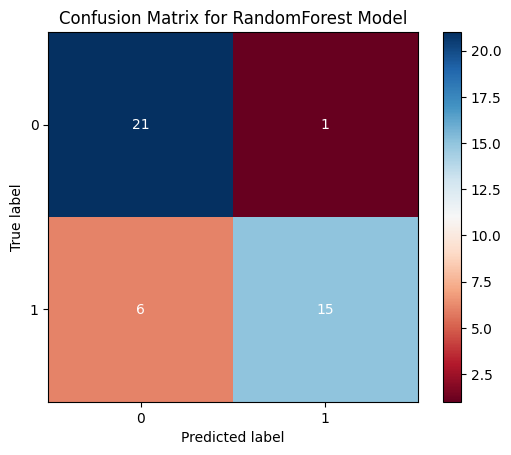

In [362]:
cm = confusion_matrix(y_test, rfc_pred, labels=rfc.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rfc.classes_)

fig, ax = plt.subplots()
disp.plot(cmap='RdBu', ax=ax, text_kw={'color': 'white'})
plt.title('Confusion Matrix for RandomForest Model')
plt.show()

There is one false positive, meaning the truck device was predicted to fail but did not. There are six false negatives, where the truck device actually failed but was not predicted to do so. In the case of truck device failures, it's more critical to minimize false negatives so that real failures can be detected before they occur.

In [396]:
features_names = features.columns
importances = rfc.feature_importances_

feature_importances = pd.DataFrame({'Feature': features_names, 'Importance': importances}).sort_values(by='Importance', ascending=False)

top_10_features = pd.DataFrame(feature_importances.reset_index(drop=True).sort_values(by='Importance', ascending=False).head(10))
top_10_features

,Feature,Importance
0,cat_2_0.0,0.118243
1,cat_num,0.075590
2,num_2,0.064700
3,work_day,0.061608
4,num_1,0.055468
5,cat_4_0.0,0.046302
6,quarter_1.0,0.013501
7,cat_3_8.0,0.012196
8,cat_4_16.0,0.011028
9,cat_2_1.0,0.010947


The top 10 important features identified by the RandomForest Classifier are listed above. The most important feature is 'cat_2_0,' a categorical feature with a value of 0. The next is the 'cat_num' feature, which I initially wasn’t sure whether to treat as categorical or numerical. I ultimately treated it as numerical, and its second-place ranking in feature importance confirms it was numeric. Notably, the 'work_day' feature, which I generated to count the days the device operated, also ranked in the top 10. Additionally, the 'quarter' feature was among the top 10 most important features as well.